# Preprocessing

## download data

In [1]:
# run this cell to download data!

import os

directory_path = "data/00--raw/macro"

if not os.path.exists(directory_path) or not os.listdir(directory_path):
    !python3 -m src.fetch.pipeline


In [2]:
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset
from src.preprocess.result import ResultData


# Usage Example:

dataset_names: Optional[List[str]]

result_data = ResultData(
    datadict = True, # Optional[Dict[str, pd.DataFrame]]
    ml_ready = True, # Optional[pd.DataFrame]
    metadata = True  # Optional["Metadata"]
    )

dataset = Dataset()

result_data = dataset.get(result_data)


In [3]:
# dictionary with key=names : value=dataframe

"""
{"feature1" : dataframe}

frames in format:
year | country1 | country2 ...
2019 | value1   | value2   
"""

datadict : Dict[str, pd.DataFrame] = result_data.datadict

for key in list(datadict.keys()): 
    print(f"{key}") 

research_and_development_expenditure_percent_of_gdp
individuals_using_the_internet_percent_of_population
net_trade_in_goods_and_services_current_usd
fdi_net_inflows_current_usd
area
education_expenditures
education_years
services_value_added_percent_of_gdp
manufacturing_value_added_percent_of_gdp
net_official_development_assistance_received_current_usd
total_population
poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population
economic_activity
life_expectancy_at_birth_total_years
gdp_per_person_employed_constant_2011_ppp_usd
population_size
gini_income_inequality
petroleum_energy_production
renewables_excluding_hydro_share
energy_use_kg_of_oil_equivalent_per_capita
hydro_electric_energy_production
gas_energy_production
coal_energy_production
consumer_price_index_change
unemployment_rate_percent_of_total_labor_force
gdp_current_usd


In [4]:
from src.clean.health_check import health_check_datadict, print_health_anomalies

report = health_check_datadict(datadict)
print_health_anomalies(report)



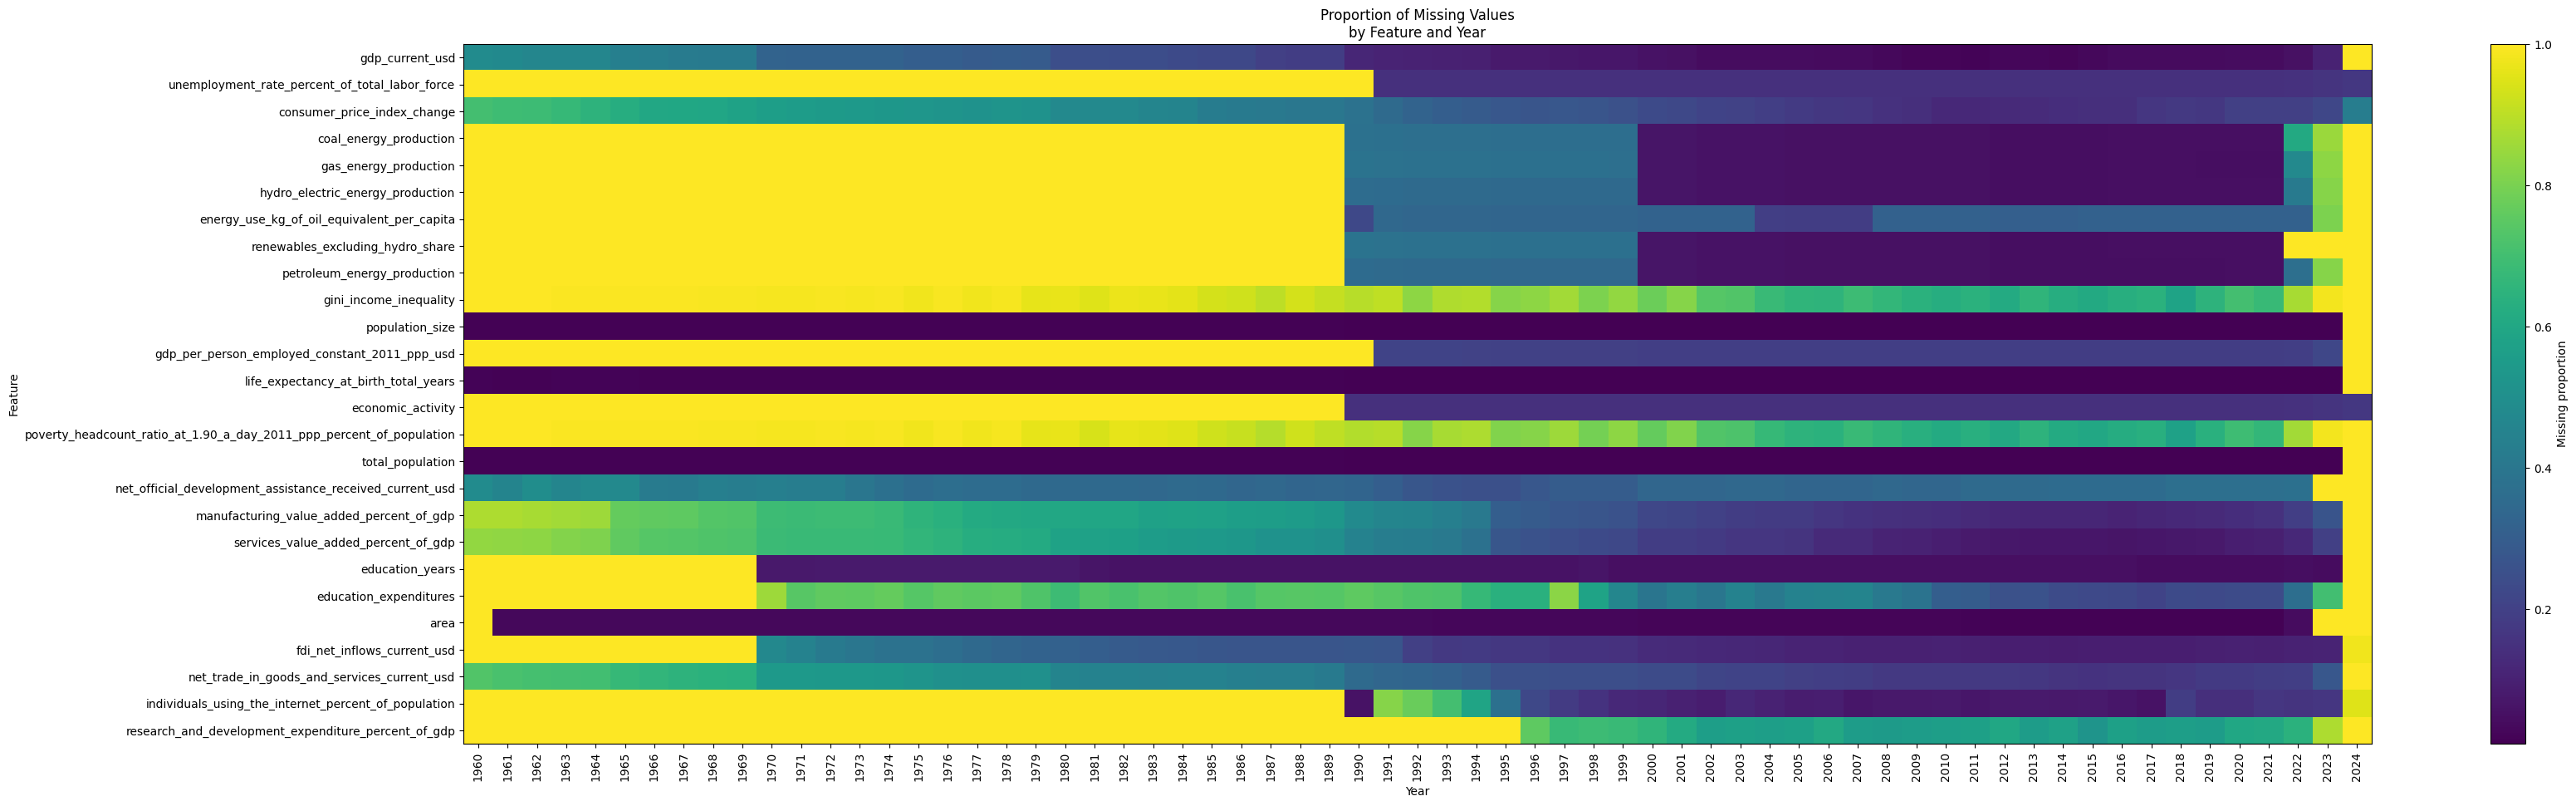

In [5]:
from src.clean.missing import compute_feature_yearly_missing, plot_feature_missing_heatmap

hm = compute_feature_yearly_missing(datadict)

plot_feature_missing_heatmap(hm)


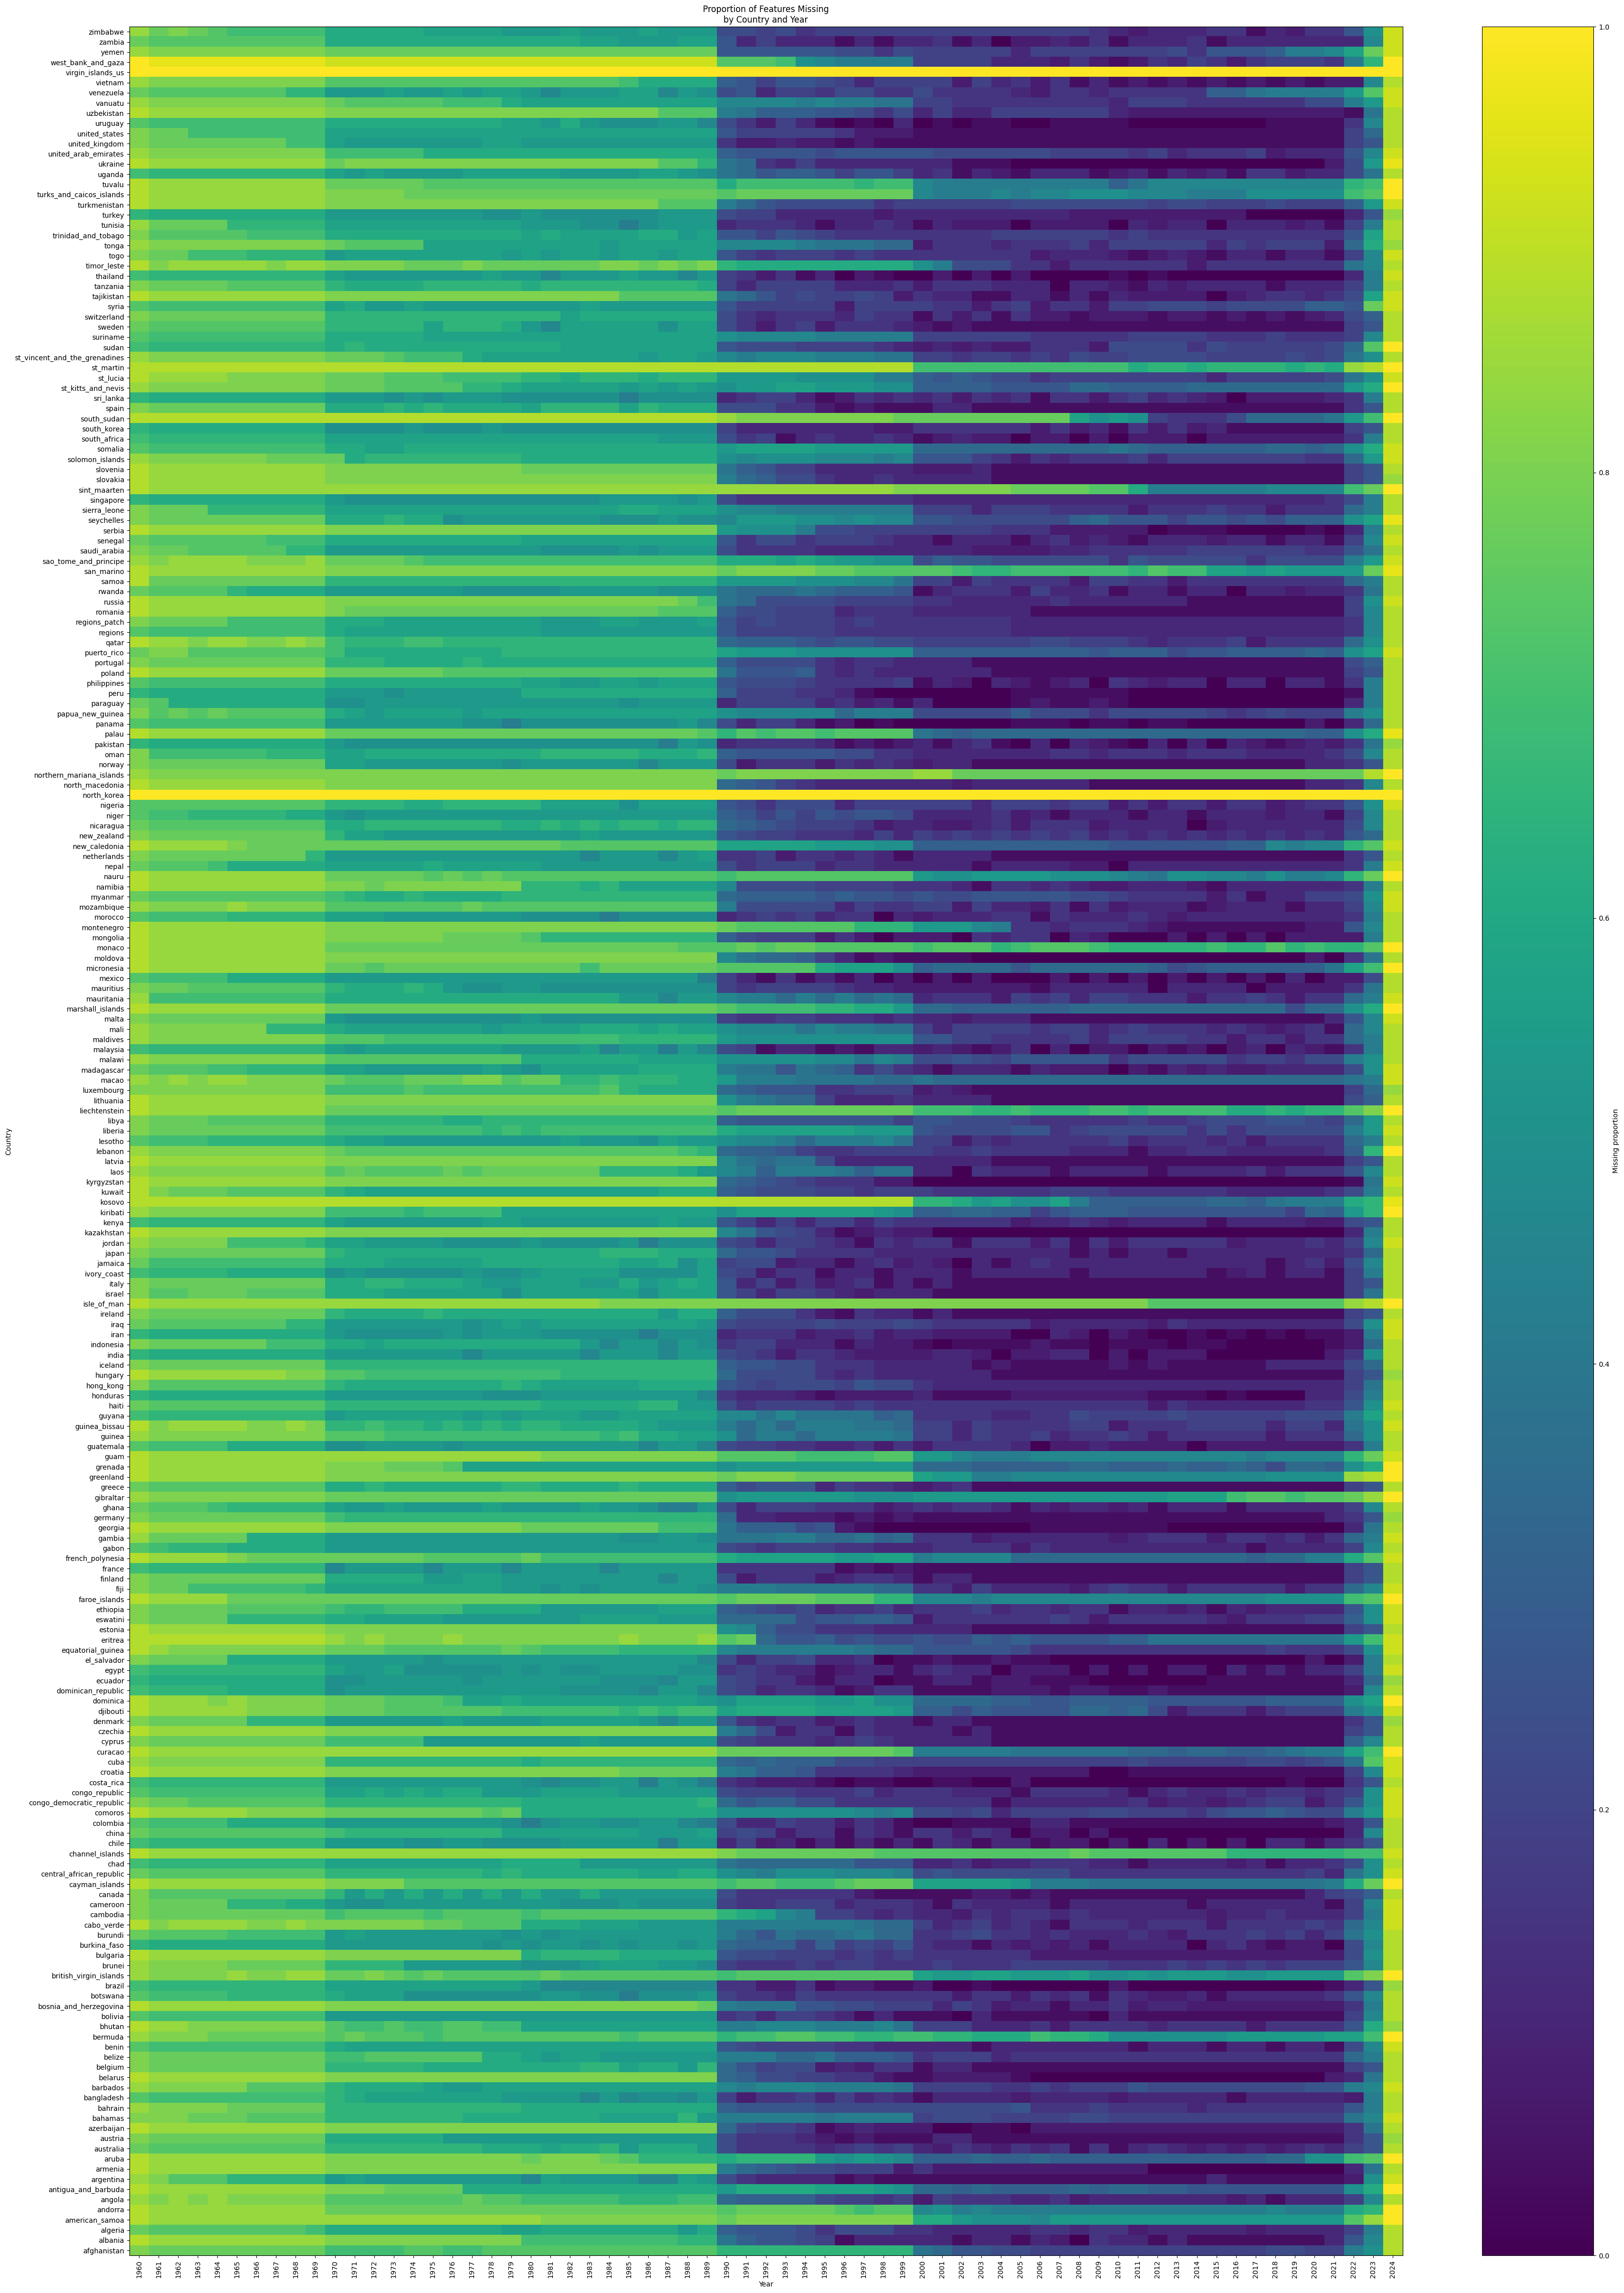

In [6]:

from src.clean.missing import compute_country_yearly_missing, plot_country_missing_heatmap


cty_hm = compute_country_yearly_missing(datadict)
plot_country_missing_heatmap(cty_hm)


In [7]:
ml = result_data.ml_ready

features = [c for c in ml.columns if c not in ("date", "country")]

na_per_feature = ml[features].isna().sum().sort_values(ascending=False)
print("Missing values per feature (all countries):")
print(na_per_feature.to_markdown(), "\n")

na_per_country = (
    ml
    .groupby("country")[features]
    .apply(lambda df: df.isna().sum().sum())
    .sort_values(ascending=False)
)
print("Missing values per country (all features):")
print(na_per_country.to_markdown())


Missing values per feature (all countries):
|                                                                      |     0 |
|:---------------------------------------------------------------------|------:|
| gini_income_inequality                                               | 12124 |
| poverty_headcount_ratio_at_1.90_a_day_2011_ppp_percent_of_population | 12040 |
| research_and_development_expenditure_percent_of_gdp                  | 11822 |
| energy_use_kg_of_oil_equivalent_per_capita                           |  9153 |
| education_expenditures                                               |  8959 |
| gdp_per_person_employed_constant_2011_ppp_usd                        |  8413 |
| renewables_excluding_hydro_share                                     |  8312 |
| individuals_using_the_internet_percent_of_population                 |  8199 |
| coal_energy_production                                               |  8174 |
| gas_energy_production                                          